# Models Trained on Tumor and Healthy Images (balanced data)

In [1]:
# import necessary libraries
import numpy as np
from torch import nn
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from IPython.display import display
from utils import *

In [2]:
! pip install git+https://github.com/davidbau/baukit

^C


Define Global Variable

In [3]:
paper_transform = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor() ])

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/davidbau/baukit to c:\users\j-dog\appdata\local\temp\pip-req-build-4o9qxdol
  Resolved https://github.com/davidbau/baukit to commit 9d51abd51ebf29769aecc38c4cbef459b731a36e
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/davidbau/baukit 'C:\Users\J-Dog\AppData\Local\Temp\pip-req-build-4o9qxdol'


In [4]:
adj_transform = transforms.Compose([
    transforms.ToTensor(),  
    torchvision.transforms.Grayscale(num_output_channels=1),
    # Convert images to tensors
    transforms.Normalize((0.,), (1.,))  # Normalize image tensors
])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Train and Evaluate Adjusted Model

In [6]:
# create train, validition, and test sets
adj_train_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/train',
    transform=adj_transform
)

adj_train_loader = torch.utils.data.DataLoader(
    adj_train_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,  
    pin_memory=True,
)

adj_val_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/validation',
    transform=adj_transform
)

adj_val_loader = torch.utils.data.DataLoader(
    adj_val_set,
    batch_size=128,
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
)

adj_test_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/test',
    transform=adj_transform
)

adj_test_loader = torch.utils.data.DataLoader(
    adj_test_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,  
    pin_memory=True,
)

epoch: 1/15 | train loss=1.2350, train_acc=0.3873 | val loss: 1.2402, val_acc=0.3967
epoch: 2/15 | train loss=0.9220, train_acc=0.5664 | val loss: 1.2067, val_acc=0.4000
epoch: 3/15 | train loss=0.7335, train_acc=0.6569 | val loss: 0.9756, val_acc=0.5333
epoch: 4/15 | train loss=0.6633, train_acc=0.6866 | val loss: 0.6543, val_acc=0.6900
epoch: 5/15 | train loss=0.6023, train_acc=0.7168 | val loss: 0.6503, val_acc=0.7400
epoch: 6/15 | train loss=0.5473, train_acc=0.7679 | val loss: 0.7256, val_acc=0.6600
epoch: 7/15 | train loss=0.5521, train_acc=0.7727 | val loss: 0.8567, val_acc=0.5900
epoch: 8/15 | train loss=0.5441, train_acc=0.7601 | val loss: 0.5802, val_acc=0.7167
epoch: 9/15 | train loss=0.4554, train_acc=0.8049 | val loss: 0.6203, val_acc=0.7067
epoch: 10/15 | train loss=0.3778, train_acc=0.8355 | val loss: 0.7985, val_acc=0.6500
epoch: 11/15 | train loss=0.3459, train_acc=0.8521 | val loss: 0.5374, val_acc=0.7600
epoch: 12/15 | train loss=0.3622, train_acc=0.8540 | val loss: 

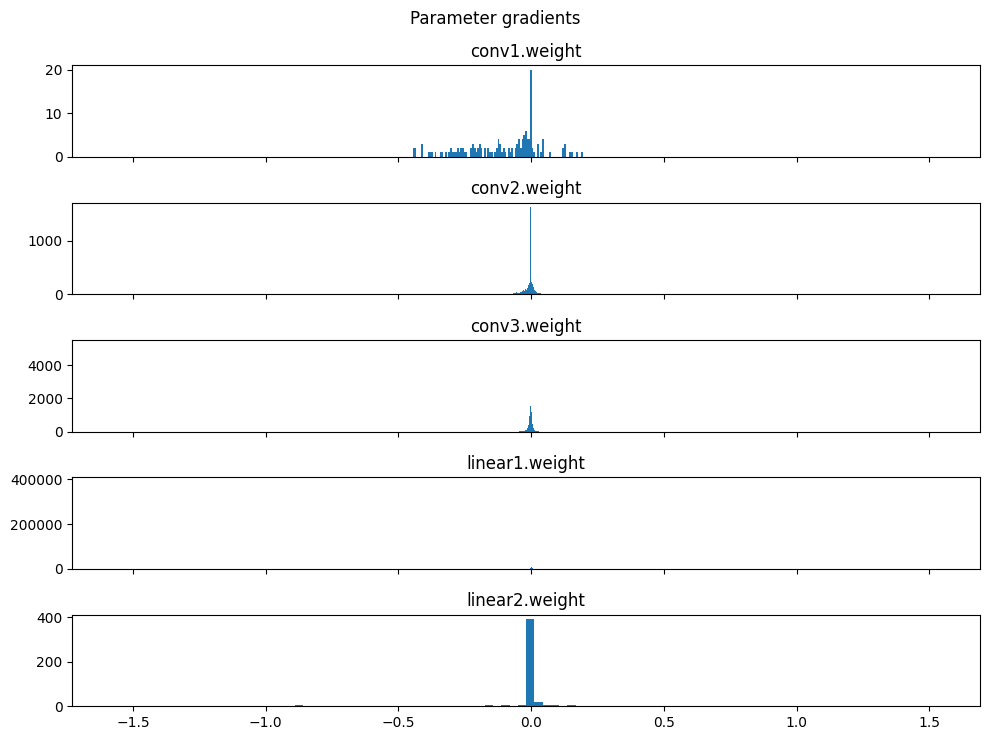

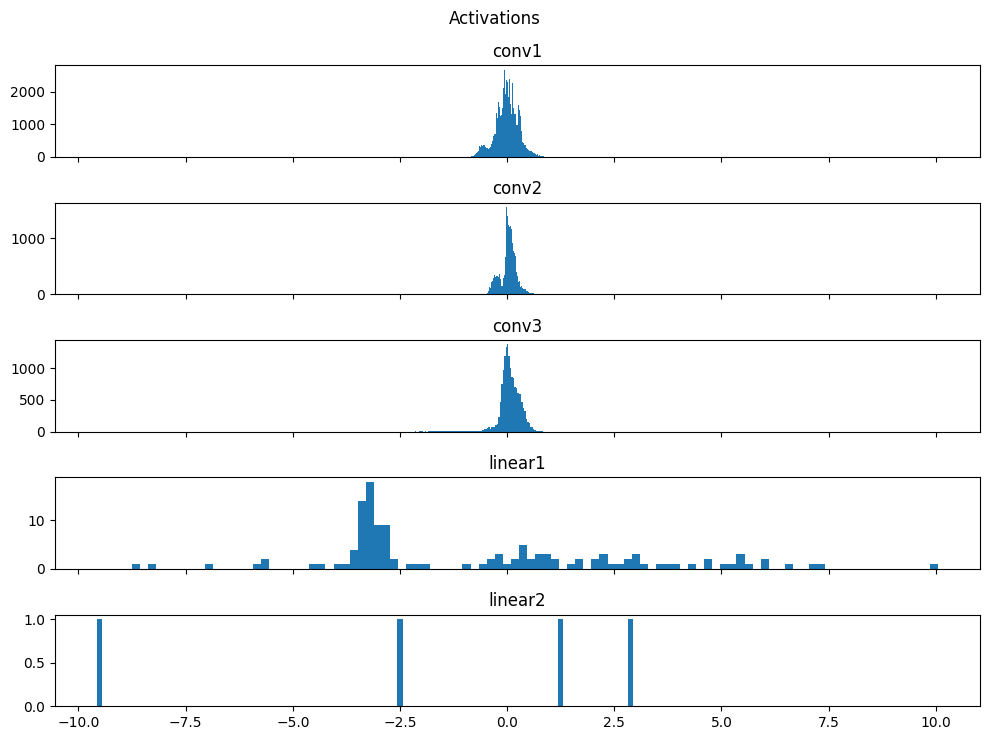

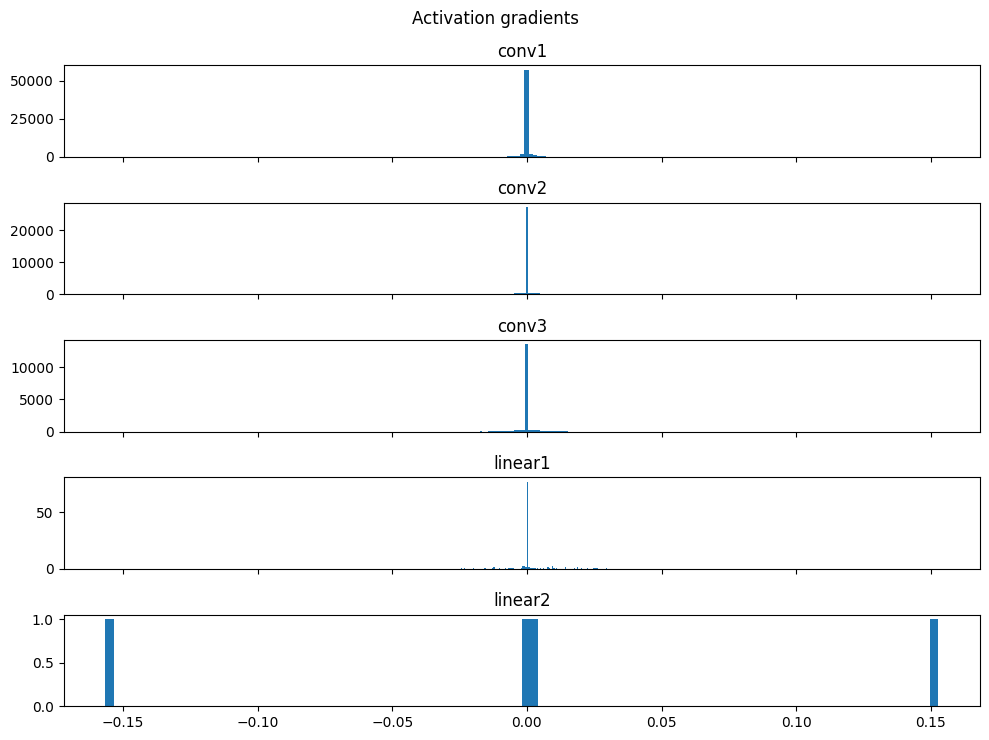

epoch: 15/15 | train loss=0.3036, train_acc=0.8686 | val loss: 0.5490, val_acc=0.7433


In [7]:
# number of classes in the dataset
num_classes = len(adj_train_set.classes)

# create adjusted model
model = BrainTumorCNN(num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 15

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []

for epoch in range(epochs):
    plot_grads = True if epoch  == 14 else False
    train_loss, train_acc = train_model(model, adj_train_loader, loss_fn, optimizer, plot_grads)
    training_losses.append(train_loss)
    training_accuracy.append(train_acc)
    val_loss, val_acc, val_precision, val_recall = evaluate_model(model, adj_val_loader, loss_fn, device)
    validation_losses.append(val_loss)
    validation_accuracy.append(val_acc)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

Test Loss: 0.5362884600957235, Test Accuracy: 0.8033333333333333, Test Precision: 0.8033333333333333, Test Recall: 0.8033333333333333


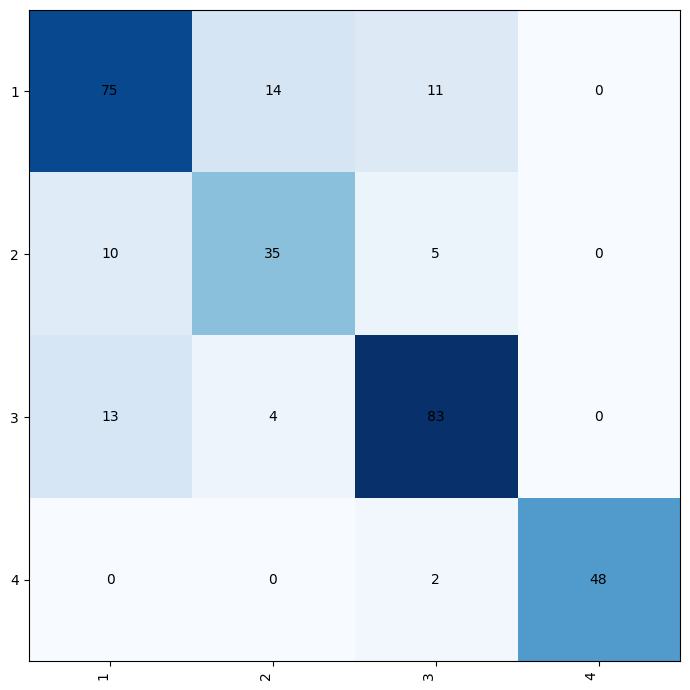

In [8]:
# get metrics and confusion matrix
test_loss, test_acc, test_precision, test_recall, test_confusion_matrix = evaluate_model(
    model, adj_test_loader, loss_fn, device, return_confusion_matrix=True
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}")
draw_confusion_matrix(test_confusion_matrix, adj_val_set, adj_train_set.classes)

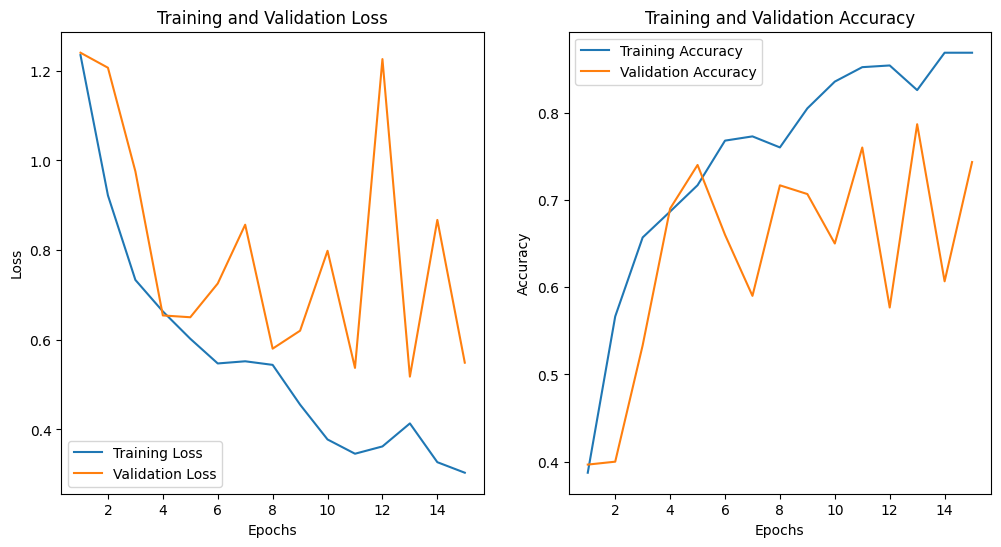

In [9]:
# plot train and val loss
plot_train_val_graphs(epochs, training_losses, training_accuracy, validation_losses, validation_accuracy)

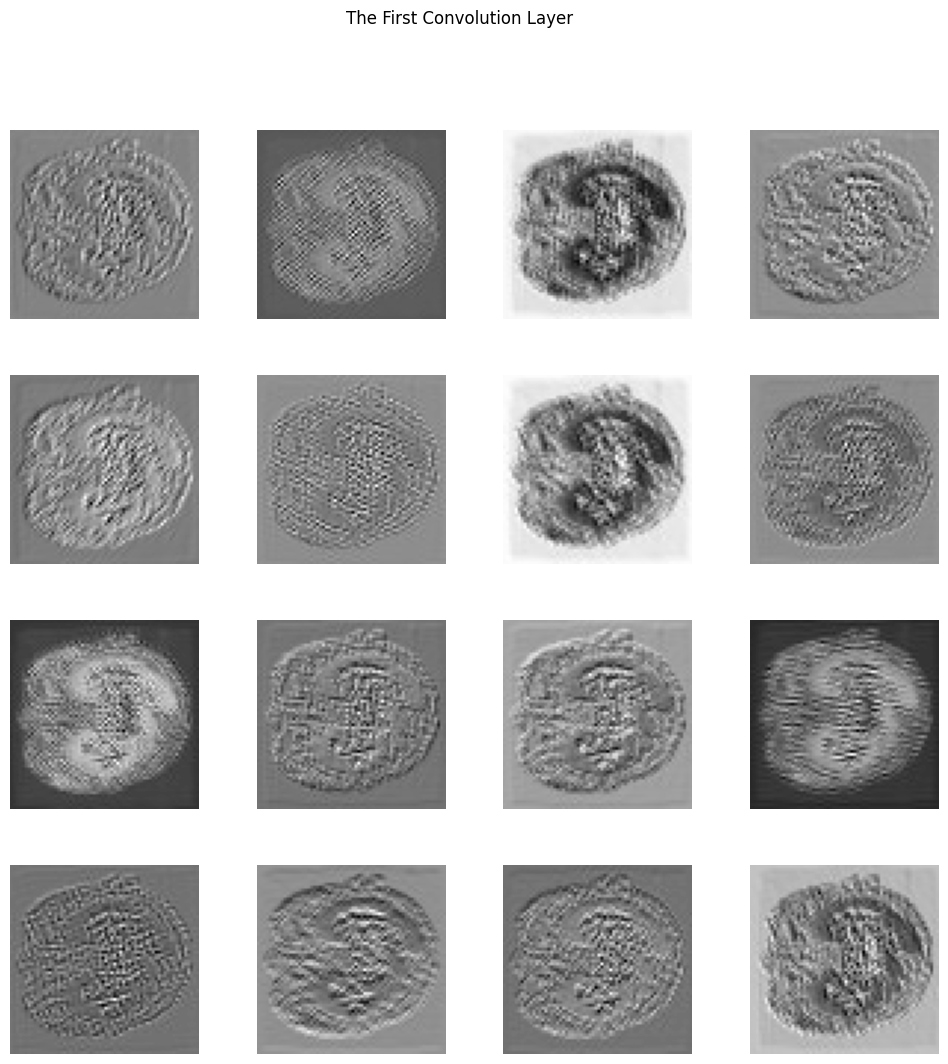

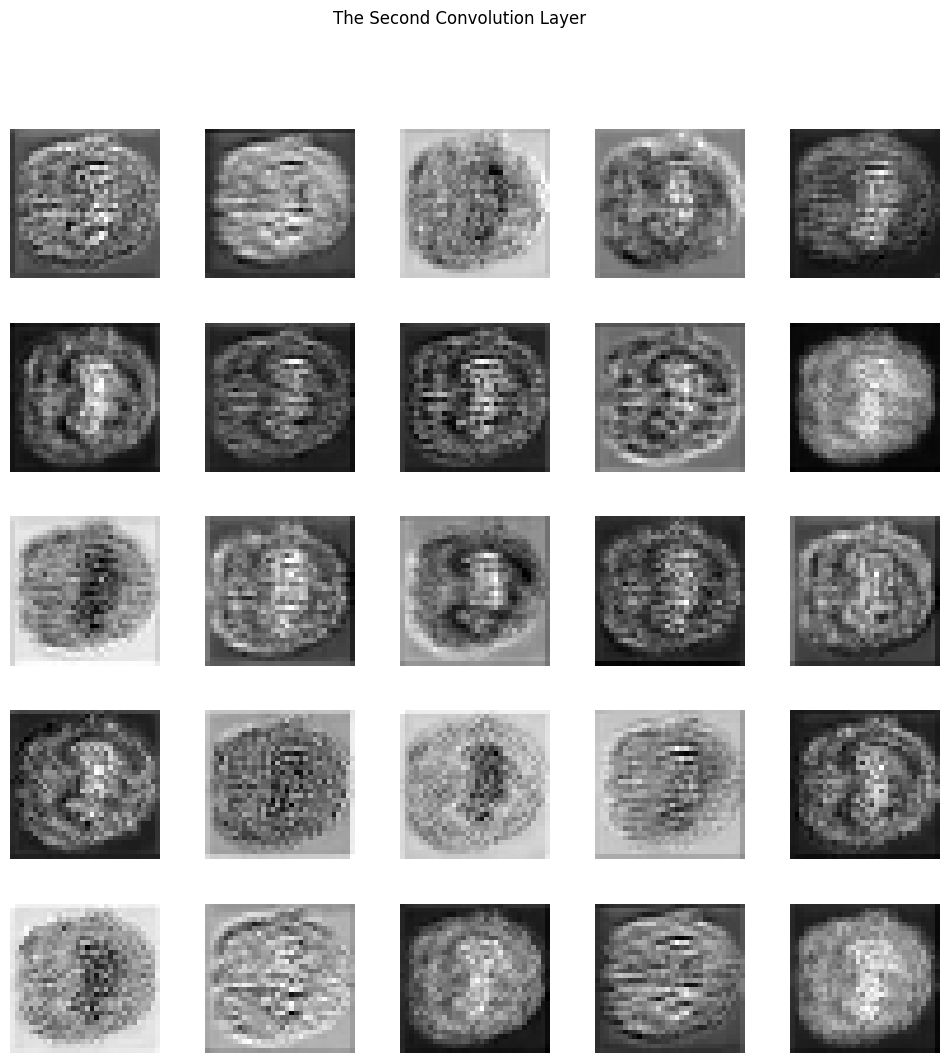

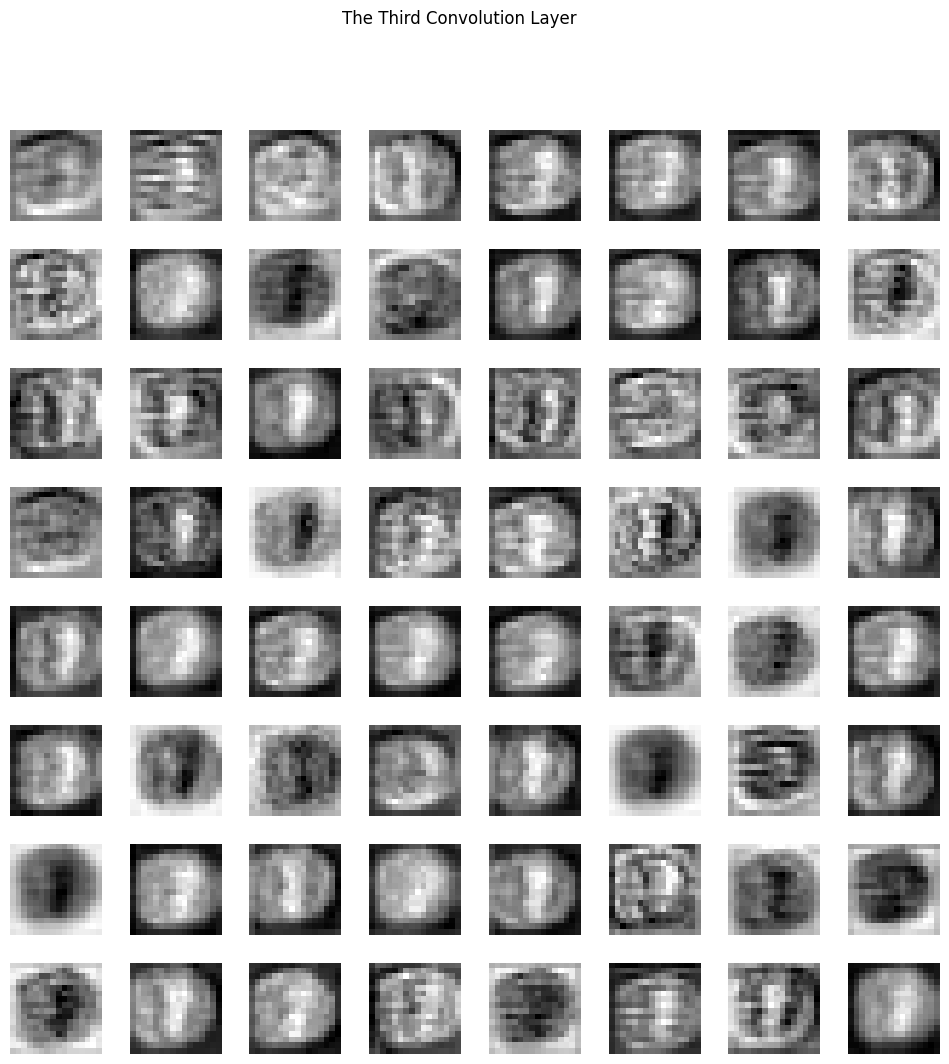

In [10]:
# observere intermediate layer outputs
visualize_con_layers_adjusted(model, device, adj_test_loader)

Train and Evaluate Paper's Model

In [7]:
# create train, validition, and test sets
pap_train_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/train',
    transform=paper_transform
)

pap_train_loader = torch.utils.data.DataLoader(
    pap_train_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,  
    pin_memory=True,
)

pap_val_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/validation',
    transform=paper_transform
)

pap_val_loader = torch.utils.data.DataLoader(
    pap_val_set,
    batch_size=128,
    shuffle=True,
    num_workers=0, 
    pin_memory=True,
)

pap_test_set = torchvision.datasets.ImageFolder(
    'imbalanced_data/tumor_healthy/test',
    transform=paper_transform
)

pap_test_loader = torch.utils.data.DataLoader(
    pap_test_set,
    batch_size=128,
    shuffle=True,
    num_workers=0,  
    pin_memory=True,
)

epoch: 1/10 | train loss=1.2546, train_acc=0.4764 | val loss: 1.3316, val_acc=0.3767
epoch: 2/10 | train loss=1.1054, train_acc=0.6394 | val loss: 1.2263, val_acc=0.5167
epoch: 3/10 | train loss=1.0374, train_acc=0.7012 | val loss: 1.1473, val_acc=0.5900
epoch: 4/10 | train loss=0.9955, train_acc=0.7509 | val loss: 1.1273, val_acc=0.6067
epoch: 5/10 | train loss=1.0036, train_acc=0.7421 | val loss: 1.1366, val_acc=0.6267
epoch: 6/10 | train loss=0.9657, train_acc=0.7776 | val loss: 1.0187, val_acc=0.7133
epoch: 7/10 | train loss=0.9463, train_acc=0.8209 | val loss: 1.1193, val_acc=0.6100
epoch: 8/10 | train loss=0.9211, train_acc=0.8302 | val loss: 1.0502, val_acc=0.6667
epoch: 9/10 | train loss=0.9247, train_acc=0.8321 | val loss: 1.0984, val_acc=0.6167


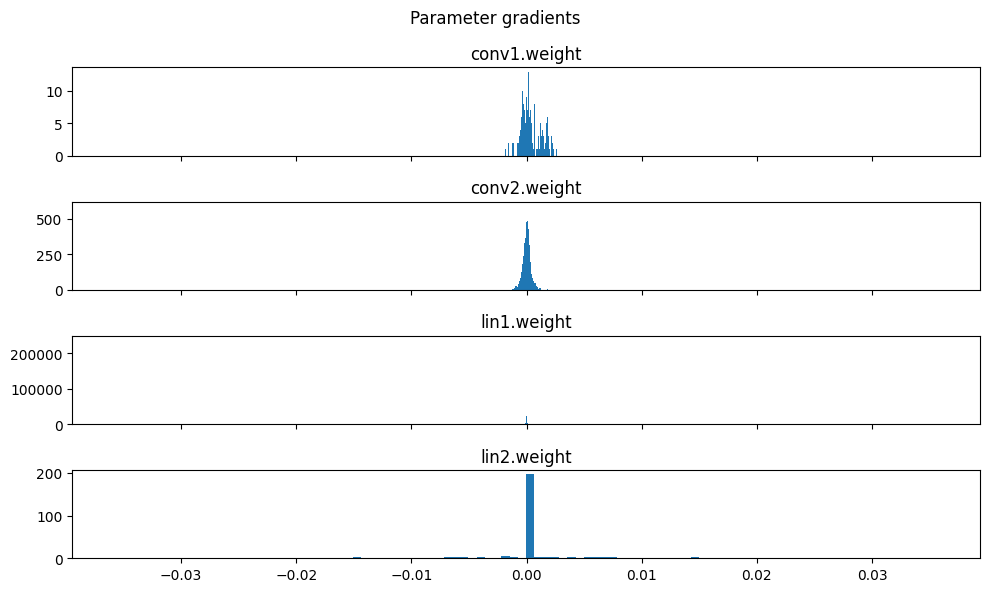

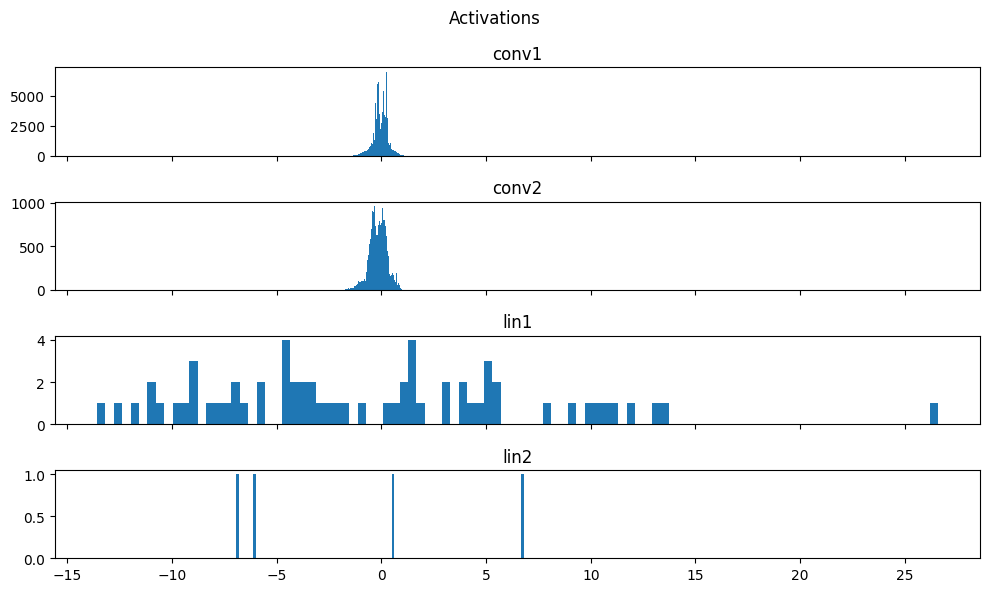

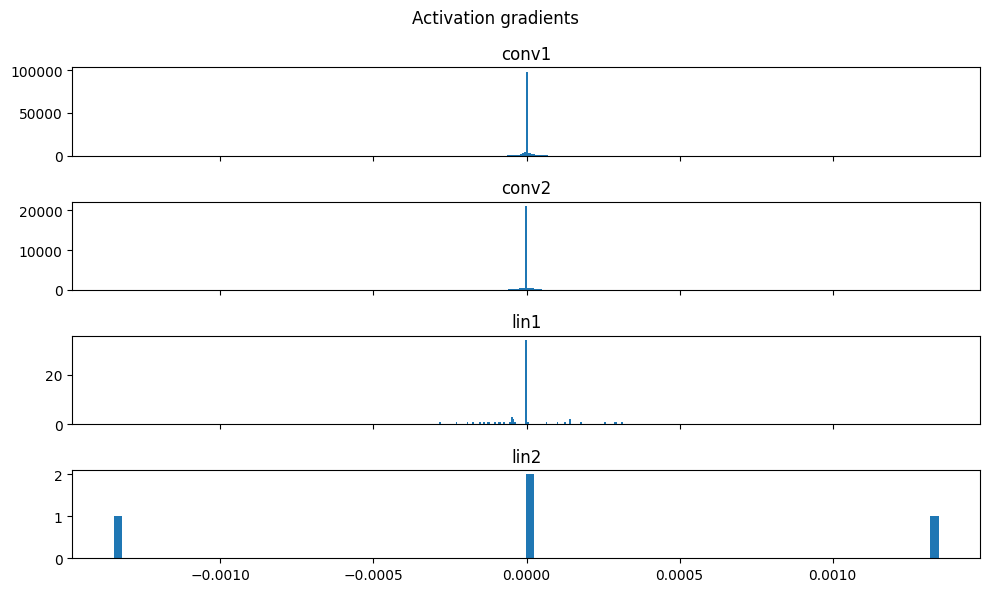

epoch: 10/10 | train loss=0.8965, train_acc=0.8560 | val loss: 1.1106, val_acc=0.6033


In [10]:
# paper's model
model = BrainTumorCLF(4).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []

for epoch in range(epochs):
    plot_grads = True if epoch  == 9 else False
    train_loss, train_acc = train_model(model, pap_train_loader, loss_fn, optimizer, plot_grads)
    training_losses.append(train_loss)
    training_accuracy.append(train_acc)
    val_loss, val_acc, val_precision, val_recall = evaluate_model(model, pap_val_loader, loss_fn, device)
    validation_losses.append(val_loss)
    validation_accuracy.append(val_acc)
    print(
        f"epoch: {epoch+1}/{epochs} | train loss={np.mean(train_loss):.4f}, {train_acc=:.4f} | val loss: {np.mean(val_loss):.4f}, {val_acc=:.4f}"
    )

Test Loss: 1.1280177036921184, Test Accuracy: 0.61, Test Precision: 0.61, Test Recall: 0.61


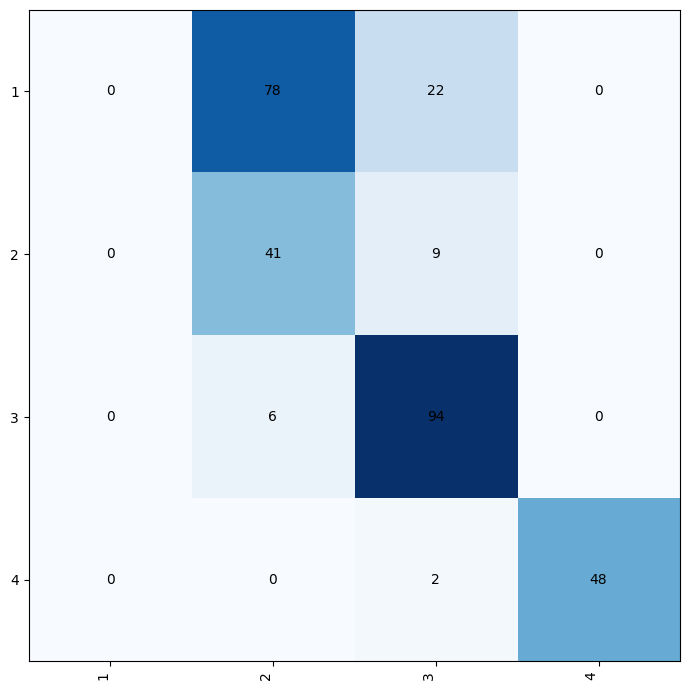

In [19]:
test_loss, test_acc, test_precision, test_recall, test_confusion_matrix = evaluate_model(
    model, pap_test_loader, loss_fn, device, return_confusion_matrix=True
)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}, Test Precision: {test_precision}, Test Recall: {test_recall}")

confusion_matrix = draw_confusion_matrix(test_confusion_matrix, pap_val_set, pap_train_set.classes)

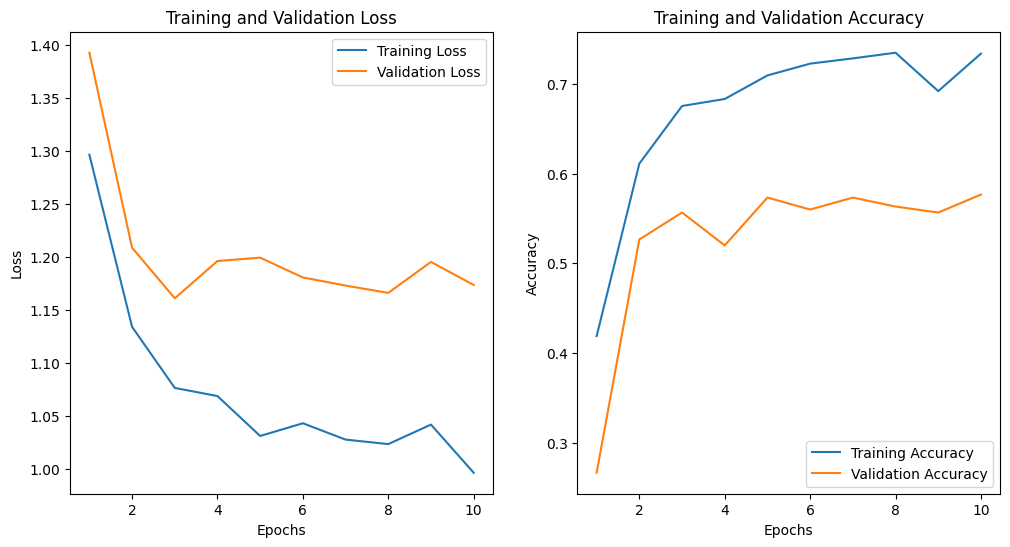

In [20]:
# plot train and val loss
plot_train_val_graphs(epochs, training_losses, training_accuracy, validation_losses, validation_accuracy)

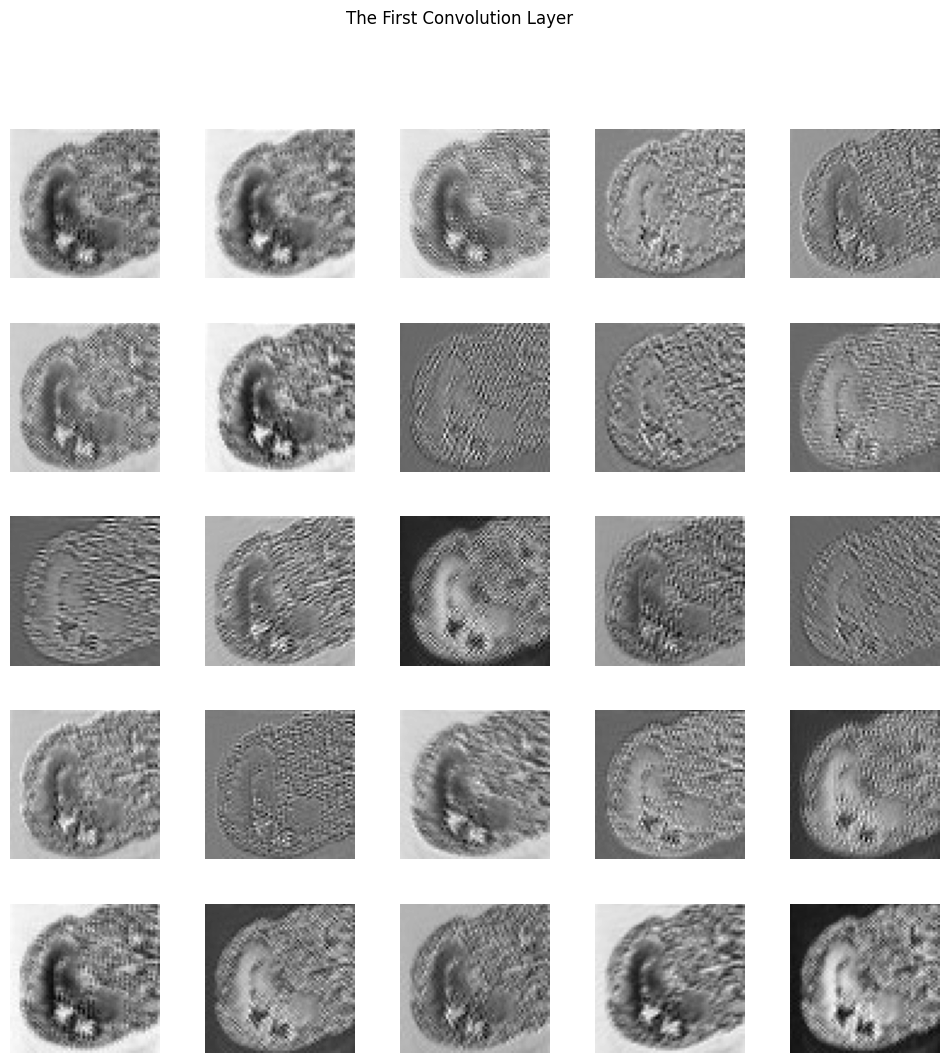

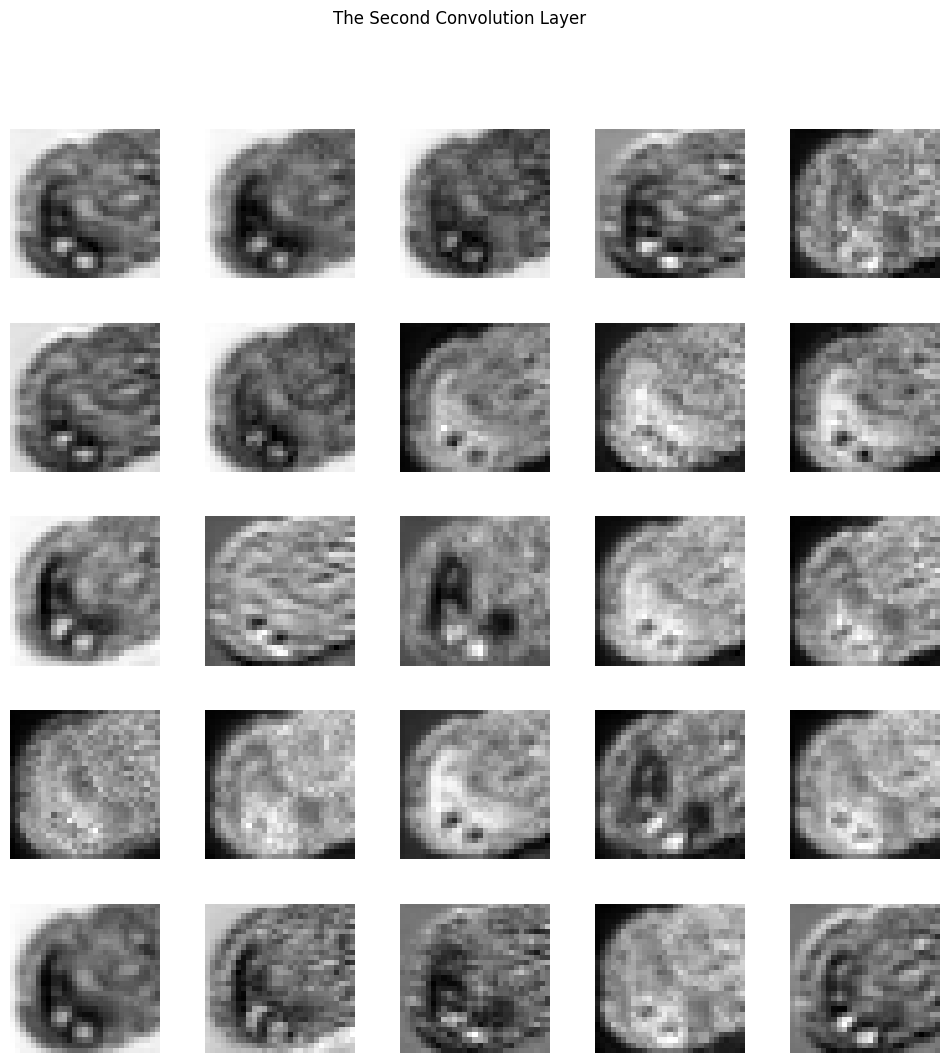

In [11]:
# observere intermediate layer outputs
visualize_con_layers_paper(model, device, pap_test_loader)